<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Subsurface Data Analytics 

### Feature Selection for Subsurface Data Analytics in Python 


#### Michael Pyrcz, Associate Professor, University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)


### Subsurface Machine Learning: Feature Ranking for Subsurface Data Analytics 

Here's a demonstration of feature ranking for subsurface modeling in Python. This is part of my Subsuface Machine Learning Course at the Cockrell School of Engineering at the University of Texas at Austin.  

#### Variable Ranking

There are often many predictor features, input variables, available for us to work with for subsurface prediction. There are good reasons to be selective, throwing in every possible feature is not a good idea! In general, for the best prediction model, careful selection of the fewest features that provide the most amount of information is the best practice. 

Here's why:

* more variables result in more complicated workflows that require more professional time and have increased opportunity for blunders
* higher dimensional feature sets are more difficult to visualize
* more complicated models may be more difficult to interrogate, interpret and QC
* inclusion of highly redundant and colinear variables increases model instability and decreases prediction accuracy in testing
* more variables generally increase the computational time required to train the model and the model may be less compact and portable
* the risk of overfit increases with the more variables, more complexity

#### What is Feature Ranking?

Feature ranking is a set of metrics that assign relative importance or value to each feature with respect to information contained for inference and importance in predicting a response feature. There are a wide variety of possible methods to accomplish this. My recommendation is a **'wide-array'** approach with multiple analyses and metrics, while understanding the assumptions and limitations of each method.  

Here's the general types of metrics that we will consider for feature ranking.

1. Visual Inspection of Data Distributions and Scatter Plots
2. Statistical Summaries
3. Model-based
4. Recursive Feature Elimination 

Also, we should not neglect expert knowledge.  If additional information is known about physical processes, causation, reliability and availability of features this should be integrated into assigning feature ranks.

#### Objective 

In the Stochastic Machine Learning class, I want to provide hands-on experience with solving complicated subsurface modeling problems with data analytics, machine learning. Python provides an excellent vehicle to accomplish this. I have coded a package called GeostatsPy with GSLIB: Geostatistical Library (Deutsch and Journel, 1998) functionality that provides basic building blocks for building subsurface modeling workflows. 

The objective is to remove the hurdles of subsurface modeling workflow construction by providing building blocks and sufficient examples. This is not a coding class per se, but we need the ability to 'script' workflows working with numerical methods.    

#### Getting Started

Here's the steps to get setup in Python with the GeostatsPy package:

1. Install Anaconda 3 on your machine (https://www.anaconda.com/download/). 
2. From Anaconda Navigator (within Anaconda3 group), go to the environment tab, click on base (root) green arrow and open a terminal. 
3. In the terminal type: pip install geostatspy. 
4. Open Jupyter and in the top block get started by copy and pasting the code block below from this Jupyter Notebook to start using the geostatspy functionality. 

You will need to copy the data file to your working directory.  They are available here:

* Tabular data - unconv_MV_v4.csv at https://git.io/fhHLT.

There are examples below with GeostatsPy functions. You can go here to see a list of the available functions, https://git.io/fh4eX, and for other example workflows and source code. 

In [1]:
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python        

We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics
import math                               # trigonometry etc.
import scipy.signal as signal             # kernel for moving window calculation
import random                             # for randon numbers
import seaborn as sns                     # for matrix scatter plots
from scipy import linalg                  # for linear regression
from sklearn.feature_selection import RFE # for recursive feature selection
from sklearn.linear_model import LinearRegression # linear regression model

Here's a couple of functions that I found online for metrics that we will calculate below.

In [3]:
#Partial Correlation in Python (clone of Matlab's partialcorr)

#This uses the linear regression approach to compute the partial correlation 
#(might be slow for a huge number of variables). The algorithm is detailed here:

# http://en.wikipedia.org/wiki/Partial_correlation#Using_linear_regression

#Taking X and Y two variables of interest and Z the matrix with all the variable minus {X, Y},
#the algorithm can be summarized as
#    1) perform a normal linear least-squares regression with X as the target and Z as the predictor
#    2) calculate the residuals in Step #1
#    3) perform a normal linear least-squares regression with Y as the target and Z as the predictor
#    4) calculate the residuals in Step #3
#    5) calculate the correlation coefficient between the residuals from Steps #2 and #4; 
#    The result is the partial correlation between X and Y while controlling for the effect of Z

#Date: Nov 2014
#Author: Fabian Pedregosa-Izquierdo, f@bianp.net
#Testing: Valentina Borghesani, valentinaborghesani@gmail.com

def partial_corr(C):
#    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
#    for the remaining variables in C.

#    Parameters
#    C : array-like, shape (n, p)
#        Array with the different variables. Each column of C is taken as a variable
#    Returns
#    P : array-like, shape (p, p)
#        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
#        for the remaining variables in C.

    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def semipartial_corr(C): # Michael Pyrcz modified the function above by Fabian Pedregosa-Izquierdo, f@bianp.net for semipartial correlation
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] # just use the value, not a residual
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [4]:
os.chdir("d:/PGE383")                     # set the working directory

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object.  

In [5]:
df = pd.read_csv('unconv_MV_v4.csv')      # load our data table (wrong name!)

Visualizing the DataFrame would be useful and we already learned about these methods in this demo (https://git.io/fNgRW). 

We can preview the DataFrame by utilizing the 'head' DataFrame member function (with a nice and clean format, see below). With the head command, add parameter 'n=13' to see the first 13 rows of the dataset.  

In [6]:
df.head(n=13)                             # we could also use this command for a table preview

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,1695.360819
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3007.096063
2,3,14.02,2.59,4.01,72.80,0.89,2.72,2531.938259
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5288.514854
4,5,17.52,4.57,3.18,10.94,1.51,1.90,2859.469624
5,6,14.53,4.81,2.69,53.60,0.94,1.67,4017.374438
6,7,13.49,3.60,2.93,63.71,0.80,1.85,2952.812773
7,8,11.58,3.03,3.25,53.00,0.69,1.93,2670.933846
8,9,12.52,2.72,2.43,65.77,0.95,1.98,2474.048178
9,10,13.25,3.94,3.71,66.20,1.14,2.65,2722.893266


This dataset has features from 200 unconventional wells including: 

0. well index
1. well average porosity (%) 
2. permeability (mD)
3. accoustic impedance (kg/m2s*10^6)
4. brittness ratio (%) 
5. total organic carbon (%) 
6. vitrinite reflectance (%)
8. normalized initial production 90 day average (MCFPD). 

Note, the dataset is synthetic, but has realistic ranges and general multivariate relationships.

Ranking features is really an effort to understand the features and their relationships with eachother.  We will start with basic data visualization and move to more complicated methods such are partial correlation and recursive feature elimination.

## Statistics

Let's start with basic summary statistics and then work our way up to more complicated statistics.

### Ranking Method - Summary Statistics

In any multivariate work we should start with the univariate analysis, summary statistics of one variable at a time. The summary statistic ranking method is qualitative, we are asking:

* are there data issues?
* do we trust the features? do we we trust the features all equally?
* are there issues that need to be taken care of before we develop any multivariate workflows?

There are a lot of efficient methods to calculate summary statistics from tabular data in DataFrames. The describe command provides count, mean, minimum, maximum, and quartiles all in a compact data table. We use transpose() command to flip the table so that features are on the rows and the statistics are on the columns.

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Well,200.0,100.500000,57.879185,1.000000,50.750000,100.500000,150.250000,200.000000
Por,200.0,14.991150,2.971176,6.550000,12.912500,15.070000,17.402500,23.550000
Perm,200.0,4.330750,1.731014,1.130000,3.122500,4.035000,5.287500,9.870000
AI,200.0,2.968850,0.566885,1.280000,2.547500,2.955000,3.345000,4.630000
Brittle,200.0,48.161950,14.129455,10.940000,37.755000,49.510000,58.262500,84.330000
TOC,200.0,0.990450,0.481588,-0.190000,0.617500,1.030000,1.350000,2.180000
VR,200.0,1.964300,0.300827,0.930000,1.770000,1.960000,2.142500,2.870000
Prod,200.0,3864.407081,1553.277558,839.822063,2686.227611,3604.303507,4752.637556,8590.384044


Summary statistics are a critical first step in data checking. 

* this includes the number of valid (non-null) values for each feature (count removes all np.NaN from the totals for each variable).

* we can see the general behavoirs such as central tendency, mean, and dispersion, variance. 

* we can identify issue with negative values, extreme values, and values that are outside the range of plausible values for each property. 

We have some negative TOC values! Let's check the distribution.

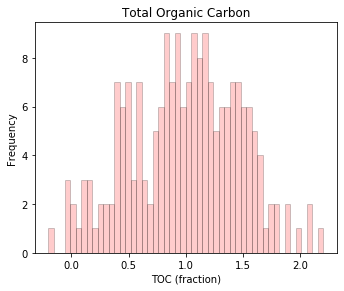

In [8]:
plt.subplot(111)
GSLIB.hist_st(df['TOC'].values,-.2,2.2,log=False,cumul = False,bins=50,weights = None,xlabel='TOC (fraction)',title='Total Organic Carbon')
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.7, top=0.8, wspace=0.1, hspace=0.2)
plt.show()

    There are just a couple slighly negative values, let's just truncate them at zero. We   can use this command below to set all TOC values in the DataFrame that are less than 0.0 as 0.0, otherwise we keep the original TOC value.

In [9]:
df['TOC'] = np.where(df['TOC']<0.0, 0.0, df['TOC']) # set TOC < 0.0 as 0.0, otherwise leave the same
df['TOC'].describe().transpose()          # summary statistics just for TOC

count    200.000000
mean       0.991950
std        0.478264
min        0.000000
25%        0.617500
50%        1.030000
75%        1.350000
max        2.180000
Name: TOC, dtype: float64

* We can also establish the feature ranges for plotting.  We could calculate the feature range directly from the data with code like this:

```p
Pormin = np.min(df['Por'].values)          # extract ndarray of data table column
Pormax = np.max(df['Por'].values)          # and calculate min and max
```

but, this would not result in easy to understand color bars and axis scales, let's pick convenient round numbers. We will also declare feature labels for ease of plotting. 

In [10]:
pormin = 6.0; pormax = 24.0; porname = 'Porosity (%)'; portitle = 'Porosity' # user specified min and max values, and labels for plotting
permmin = 0.0; permmax = 10; permname = 'Permeability (mD)'; permtitle = 'Permeability'                
AImin = 1.0; AImax = 5.0; AIname = 'Acoustic Impedance (kg/m2s*10^6)'; AItitle = 'Acoustic Impedance'
brmin = 10.0; brmax = 85.0; brname = 'Brittleness Ratio (%)'; brtitle = 'Brittleness'
TOCmin = 0.0; TOCmax = 2.2; TOCname = 'Total Organic Carbon (%)'; TOCtitle = 'Total Organic Carbon' 
VRmin = 0.9; VRmax = 2.9; VRname = 'Vitrinite Reflectance (%)'; VRtitle = 'Vitrinite Reflectance'
prodmin = 500.0; prodmax = 9000.0; prodname = 'Normalized Initial Production (MCFPD)'; prodtitle = 'Normalized Initial Production'

The data looks to be in pretty good shape and for brevity we skip outlier detection. Let's look at the distributions.

### Ranking Method - Univariate Distributions

As with summary statistics, this ranking method is a qualitative check for issues with the data and to assess our confidence with each feature. It is better to not include a feature with low confidence of quality as it may be misleading (while adding to model complexity as discussed previously).  

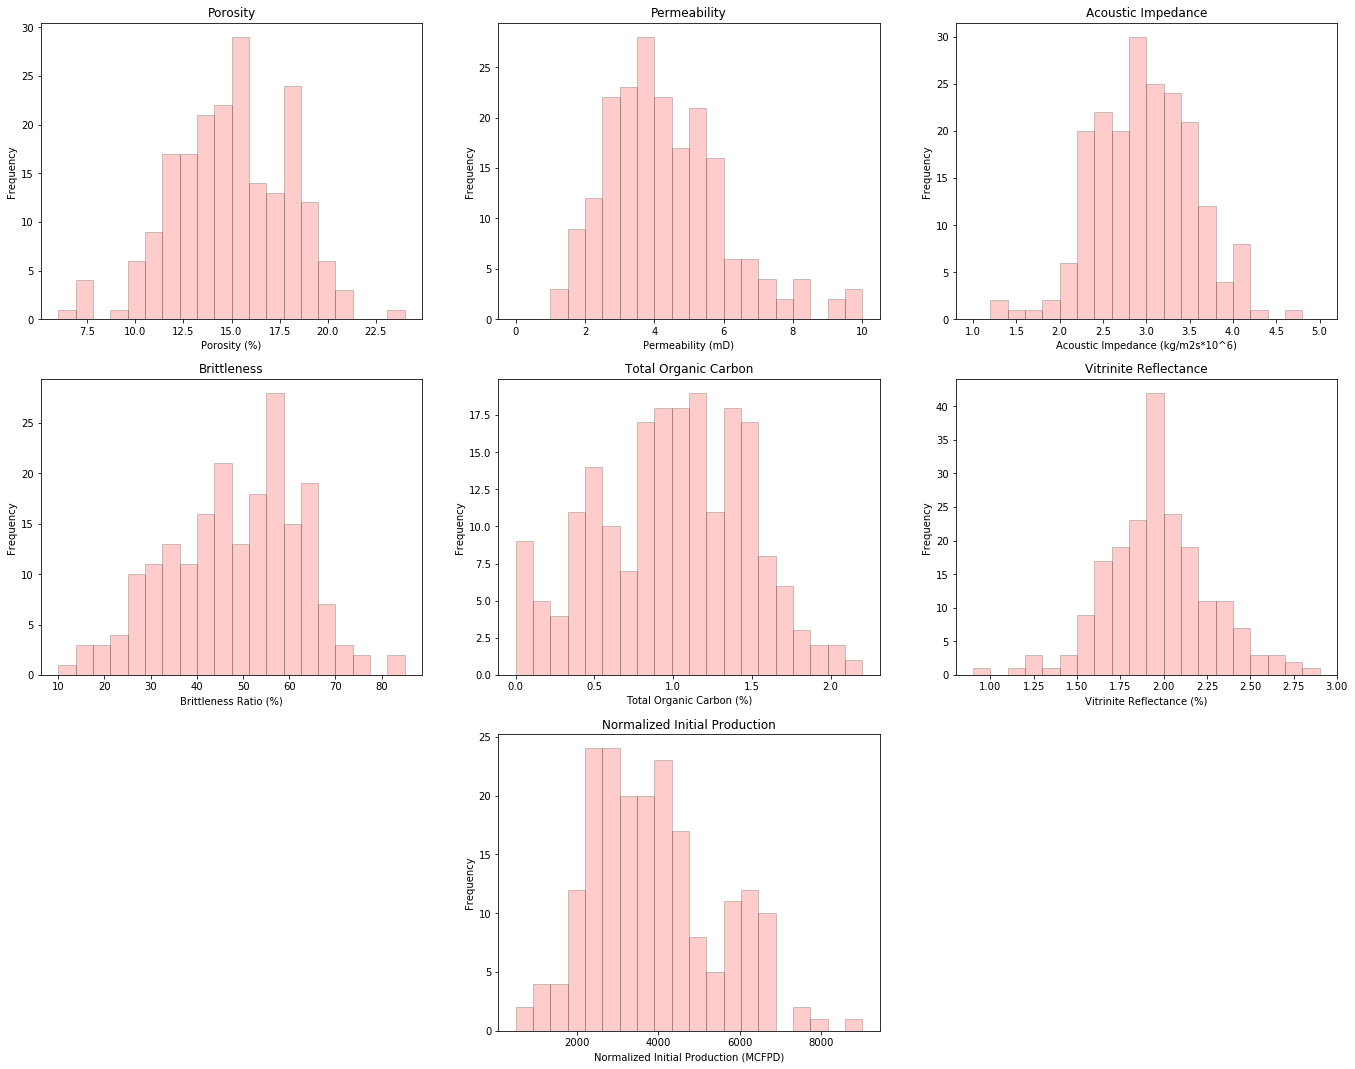

In [11]:
plt.subplot(331)
GSLIB.hist_st(df['Por'].values,pormin,pormax,log=False,cumul = False,bins=20,weights = None,xlabel=porname,title=portitle)

plt.subplot(332)
GSLIB.hist_st(df['Perm'].values,permmin,permmax,log=False,cumul = False,bins=20,weights = None,xlabel=permname,title=permtitle)

plt.subplot(333)
GSLIB.hist_st(df['AI'].values,AImin,AImax,log=False,cumul = False,bins=20,weights = None,xlabel=AIname,title=AItitle)

plt.subplot(334)
GSLIB.hist_st(df['Brittle'].values,brmin,brmax,log=False,cumul = False,bins=20,weights = None,xlabel=brname,title=brtitle)

plt.subplot(335)
GSLIB.hist_st(df['TOC'].values,TOCmin,TOCmax,log=False,cumul = False,bins=20,weights = None,xlabel=TOCname,title=TOCtitle)

plt.subplot(336)
GSLIB.hist_st(df['VR'].values,VRmin,VRmax,log=False,cumul = False,bins=20,weights = None,xlabel=VRname,title=VRtitle)

plt.subplot(338)
GSLIB.hist_st(df['Prod'].values,prodmin,prodmax,log=False,cumul = False,bins=20,weights = None,xlabel=prodname,title=prodtitle)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.5, wspace=0.2, hspace=0.2)
plt.savefig('hist_Porosity_Multiple_bins.tif',dpi=600,bbox_inches="tight")
plt.show()

The univariate distributions look good:

* there are no obvious outliers
* the permeability is postively skewed as often observed
* the corrected TOC has a small spike, but it's reasonable

### Ranking Method - Bivariate Distributions

Matrix scatter plots are a very efficient method to observe the bivarate relationships between the variables.  

* this is another opportunity through data visualization to identify data issues
* we can assess if we have collinearity, specifically simpler form between two features at a time. 

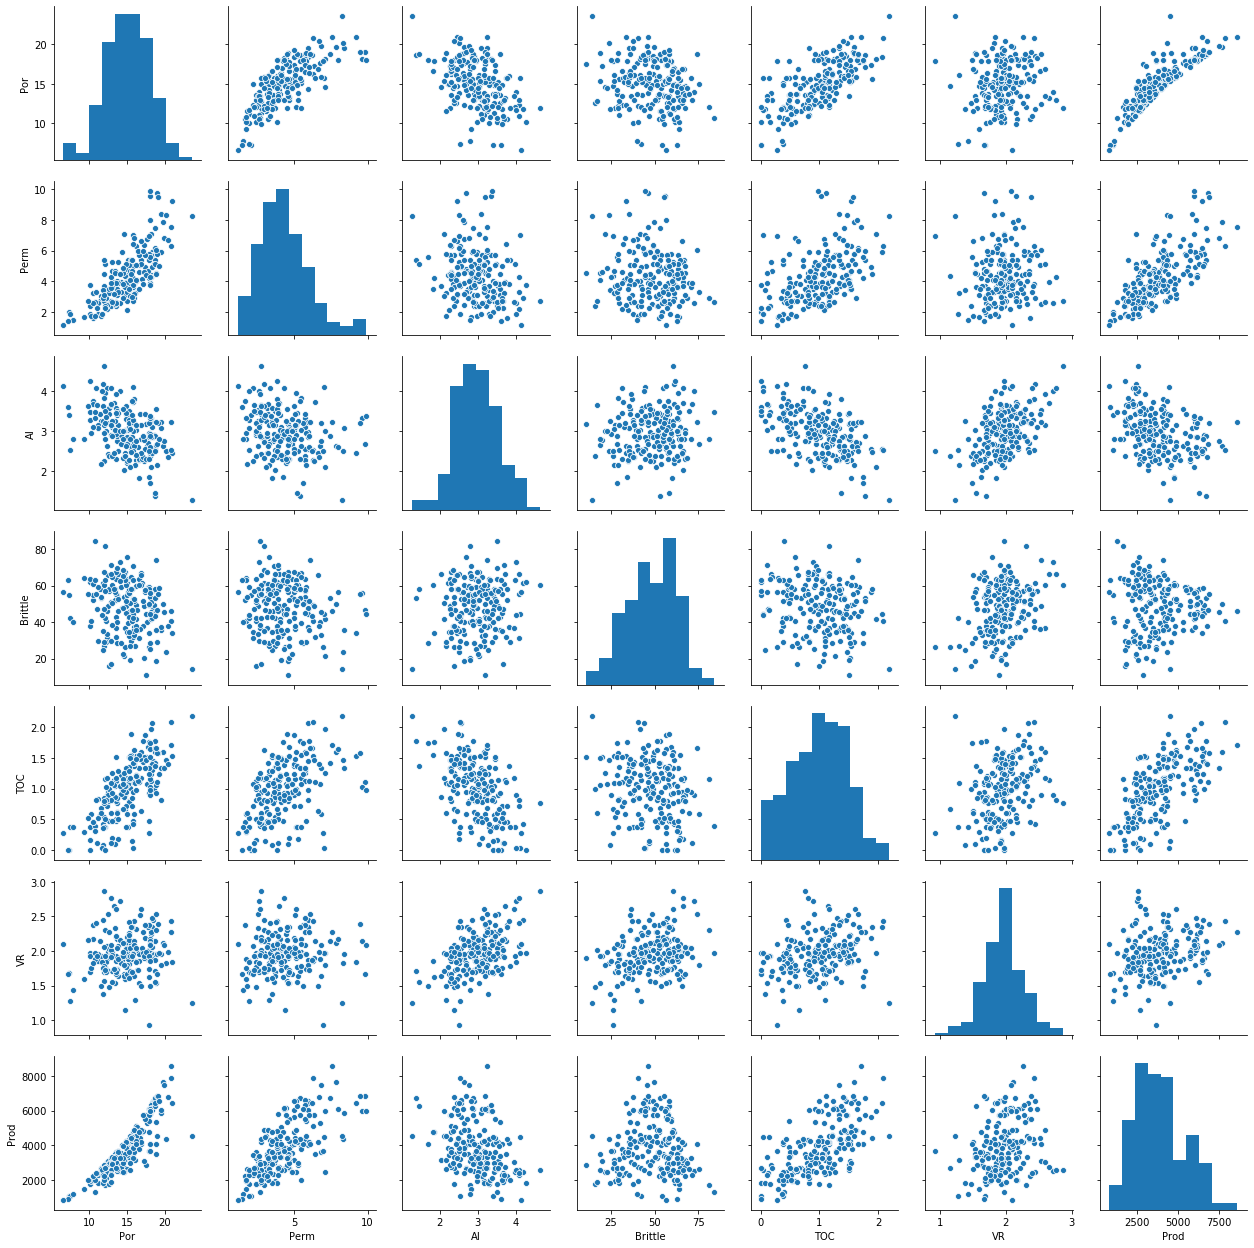

In [12]:
sns.pairplot(df,vars=['Por','Perm','AI','Brittle','TOC','VR','Prod'],markers='o')

This plot communicates a lot of information. How could we use this plot for variable ranking?

* we can identify variables that are closely related to eachother.  e.g. if two variables have almost a perfect monotonic linear or near linear relationship we should remove one immediately.  This is a simple case of colinearity that will likley result in model instability as discussed above.

* we can check for linear vs. non-linear relationships.  If we observe nonlinear bivariate relationships this will impact the choice of methods, and the quality of results from methods that assume linear relationships for variable ranking.

* we can identify constraint relationships and heteroscedasticity between variables. Once again these may restrict our ranking methods and also encourage us to retains specific features to retain these features in the resulting model. 

Yet, we must remember that bivariate visualization and analysis is not sufficient to understand all the multivariate relationships in the data. Multicollinearity includes strong linear relationships between 2 or more features. These may be hard to see with only bivariate plots.

### Ranking Method - Pairwise Covariance

Pairwise covariance provides a measure of the strength of the linear relationship between each predictor feature and the response feature. At this point, we specify that the goal of this study is to predict production, our response variable, from the other available predictor features.  We are thinking predictively now, not inferentially, we want to estimate the function, $\hat{f}$, to accomplish this:

\begin{equation}
Y = \hat{f}(X_1,\ldots,X_n) 
\end{equation}

where $Y$ is our response feature and $X_1,\ldots,X_n$ are our predictor features.  If we retained all of our predictor features to predict the response we would have: 

\begin{equation}
Prod = \hat{f}(Por,Perm,AI,Brittle,TOC,VR) 
\end{equation}

Now back to the covariance, the covariance is defined as:  

\begin{equation}
C_{xy}  = \frac{\sum_{i=1}^{n} (x_i - \overline{x})(y_i - \overline{y})}{(n-1)}
\end{equation}

Covariance:
* measures the linear relationship
* sensitive to the dispersion / variance of both the predictor and response

We can use the follow command to build a covariance matrix:

```p
df.iloc[:,1:8].cov()
```
the output is a new Pandas DataFrame, so we can slice the last column to get a Pandas series (ndarray with names) with the covariances between all predictors features and the response.


In [13]:
covariance = df.iloc[:,1:8].cov().iloc[6,:6]
print(covariance)

Por        4068.428763
Perm       1896.162708
AI         -323.362855
Brittle    -462.973464
TOC         474.323491
VR          107.848210
Name: Prod, dtype: float64


The covariance is useful, but as you can see the magnitude is quite variable. Most importantly these magnitudes are a function of each feature's variance. Feature variance is somewhat arbitrary. For example, what is the variance of porosity in fraction vs. percentage or permeaiblity in Darcy vs. milliDarcy. We can show that if we apply a constant multiplier, $c$, to a variable, $X$, that the variance will change according to this relationship (the proof is based on expectation formulation of variance):

\begin{equation}
\sigma_{cX}^2 = c^2 \cdot \sigma_{X}^2
\end{equation}

By moving from percentage to fraction we decrease the variance of porosity by a factor of 10,000! The variance of each variable is potentially arbitrary, with the exception when all the features are in the same units. 

Pairwise correlations avoids this issue. 

### Ranking Method - Pairwise Correlation Coefficient

Pairwise correlation coefficient provides a measure of the strength of the linear relationship between each predictor feature and the response feature.  

\begin{equation}
\rho_{xy}  = \frac{\sum_{i=1}^{n} (x_i - \overline{x})(y_i - \overline{y})}{(n-1)\sigma_x \sigma_y}, \, -1.0 \le \rho_{xy} \le 1.0
\end{equation}

The correlation coefficient:

* measures the linear relationship
* removes the sensitiviety to the dispersion / variance of both the predictor and response features, by normalizing by the product of the standard deviation of each feature 

We can use the follow command to build a correlation matrix:

```p
df.iloc[:,1:8].corr()
```
the output is a new Pandas DataFrame, so we can slice the last column to get a Pandas series (ndarray with names) with the correlations between all predictors features and the response.


In [14]:
correlation = df.iloc[:,1:8].corr().iloc[6,:6]
print(correlation)

Por        0.881555
Perm       0.705222
AI        -0.367237
Brittle   -0.021095
TOC        0.638496
VR         0.230806
Name: Prod, dtype: float64


This is interesting. 

* We see that porosity, permeability and total organic carbon have the strongest linear relationships with production. 
* Acoustic impedance has weak negative relationships with production.
* Brittleness is very close to 0.0. If you review the brittleness vs. production scatterplot, you'll observe a complicated non-linear relationship. There is a brittleness ratio sweetspot for production (rock that is not too soft nor too hard)!

We could also look at the full correlation matrix to evaluate the potential for redudancy between predictor features.

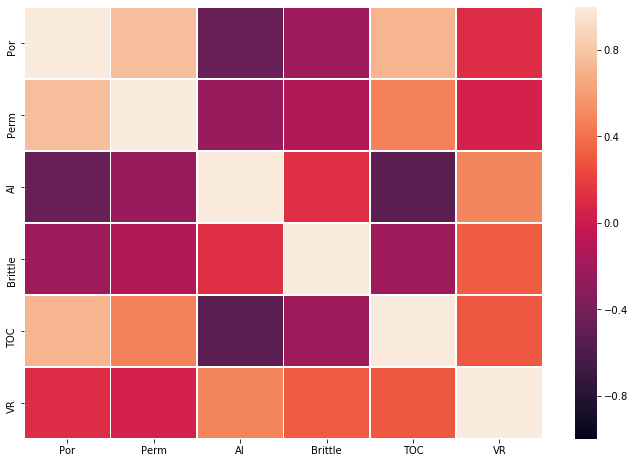

In [15]:
plt.subplot(111)                          # plot a color coded correlation matrix
sns.heatmap(df.iloc[:,1:7].corr(),vmin = -1.0, vmax = 1.0,linewidths=.5, fmt= '.1f')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

Some observations:

* strong degree of correlation between porosity and permeability and porosity and TOC

* strong degree of negative correlation between TOC and acoustic impedance

We are still limited to a strick linear relationship.  The rank correlation allows us to relax this assumption.

### Ranking Method - Pairwise Spearman Rank Correlation Coefficient

The rank correlation coefficient applies the rank transform to the data prior to calculating the correlation coefficent. To calculate the rank transform simply replace the data values with the rank $R_x = 1,\dots,n$, where $n$ is the maximum value and $1$ is the minimum value. 

\begin{equation}
\rho_{R_x R_y}  = \frac{\sum_{i=1}^{n} (R_{x_i} - \overline{R_x})(R_{y_i} - \overline{R_y})}{(n-1)\sigma_{R_x} \sigma_{R_y}}, \, -1.0 \le \rho_{xy} \le 1.0
\end{equation}

\begin{equation}
x_\alpha, \, \forall \alpha = 1,\dots, n, \, | \, x_i \ge x_j \, \forall \, i \gt j 
\end{equation}

\begin{equation}
R_{x_i} = i
\end{equation}

The rank correlation:

* measures the monotonic relationship, relaxes the linear assumption
* removes the sensitiviety to the dispersion / variance of both the predictor and response, by normalizing by the product of the standard deviation of each. 

We can use the follow command to build a rank correlation matrix and calculate the p-value:

```p
stats.spearmanr(df.iloc[:,1:8])
```
the output is a new Pandas DataFrame, so we can slice the last column to get a Pandas series (ndarray with names) with 
the correlations between all predictors features and the response.

Also, we get a very convenient *pval* 2D ndarry with the two-sided (two-tail summing semmetric over both tails) p-value for a hypothesis test with: 

\begin{equation}
H_o: \rho_{R_x R_y} = 0
\end{equation}

\begin{equation}
H_1: \rho_{R_x R_y} \ne 0
\end{equation}

Let's keep the p-values between all the predictor features and our response feature.

In [16]:
rank_correlation, rank_correlation_pval = stats.spearmanr(df.iloc[:,1:8]) # calculate the range correlation coefficient
rank_correlation = rank_correlation[:,6][:6]
rank_correlation_pval = rank_correlation_pval[:,6][:6]
print(rank_correlation)
print(rank_correlation_pval)

[ 0.9056479   0.70094589 -0.37968924 -0.05800131  0.65147269  0.25142017]
[1.04774522e-75 6.96211663e-31 2.93927576e-08 4.14609952e-01
 1.53807742e-25 3.29170847e-04]


There are some interesting results:

* we almost doubled the correlation between Brittleness and Production be relaxing the linear assumption, of course it is still low due to the monotonic assumption in with the rank correlation.
* we increased the correlation between porosity and production. See the slightly curve in the porosity and production constraint.
* only the brittleness vs. production rank correlation coefficient is not significantly different than zero

All of these methods up to now have considered one variable at a time. We can also consider methods that consider all features jointly to 'isolate' the influence of each feature.

### Ranking Method - Partial Correlation Coefficient

This is a linear correlation coefficient that controls for the effects all the remaining variables, $\rho_{XY.Z}$ and $\rho_{YX.Z}$ is the partial correlation between $X$ and $Y$, $Y$ and $X$, after controlling for $Z$.

To calculate the partial correlation coefficient between $X$ and $Y$ given $Z_i, \forall \quad i = 1,\ldots, m-1$ remaining features we use the following steps:

1. perform linear, least-squares regression to predict $X$ from $Z_i, \forall \quad i = 1,\ldots, m-1$. $X$ is regressed on the predictors to calculate the estimate, $X^*$

2. calculate the residuals in Step \#1, $X-X^*$, where $X^* = f(Z_{1,\ldots,m-1})$, linear regression model

3. perform linear, least-squares regression to predict $Y$ from $Z_i, \forall \quad i = 1,\ldots, m-1$. $Y$ is regressed on the predictors to calculate the estimate, $Y^*$

4. calculate the residuals in Step #3, $Y-Y^*$, where $Y^* = f(Z_{1,\ldots,m-1})$, linear regression model

5. calculate the correlation coefficient between the residuals from Steps #2 and #4, $\rho_{X-X^*,Y-Y^*}$

The partial correlation, provides a measure of the linear relationship between $X$ and $Y$ while controlling for the effect of $Z$ other features on both, $X$ and $Y$.  We use the function declared previously taken from Fabian Pedregosa-Izquierdo, f@bianp.net. The original code is on GitHub at https://git.io/fhyHB.

To use this method we must assume:

1. two variables to compare, $X$ and $Y$
2. other variables to control, $Z_{1,\ldots,m-2}$ 
3. linear relationships between all variables
4. no significant outliers
5. approximately bivariate normality between the variables

We are in pretty good shape, but we have some departures from bivariate normality.  We could consider Gaussian univariate transforms to improve this.  This option is provided later.

In [17]:
partial_correlation = partial_corr(df.iloc[:,1:8]) # calculate the partial correlation coefficients
partial_correlation = partial_correlation[:,6][:6] # extract a single row and remove production with itself
print(partial_correlation)

[ 0.57819874  0.33508588 -0.44876162 -0.09382873 -0.22585573  0.32797993]


Now we see a lot of new things about the unique contributions of each predictor feature! 

* porosity and permeability are strongly correlated with each other so they are penalized severely 

* acoustic impedance's and vitrinite reflectance's absolute correlation are increased reflecting their unique contributions

* total organic carbon flipped signs!  When we control for all other variables, it has a negative relationship with production. 

With the partial correlation coefficients we have controlled for the influence of all other predictor features on both the specific predictor and the response features. The semipartial correlation filters out the influence of all other predictor features on the raw response variable. 

### Ranking Method - Semipartial Correlation Coefficient

This is a linear correlation coefficient that controls for the effects all the remaining features, $Z$ on $X$, and then calculates the correlation between the residual $X^*-X$ and $Y$.  Note: we do not control for influence of $Z$ features on the response feature, $Y$. 

To calculate the semipartial correlation coefficient between $X$ and $Y$ given $Z_i, \forall \quad i = 1,\ldots, m-1$ remaining features we use the following steps:

1. perform linear, least-squares regression to predict $X$ from $Z_i, \forall \quad i = 1,\ldots, m-1$. $X$ is regressed on the remaining predictor features to calculate the estimate, $X^*$

2. calculate the residuals in Step \#1, $X-X^*$, where $X^* = f(Z_{1,\ldots,m-1})$, linear regression model

3. calculate the correlation coefficient between the residuals from Steps #2 and $Y$ response feature, $\rho_{X-X^*,Y}$

The semipartial correlation coefficient, provides a measure of the linear relationship between $X$ and $Y$ while controlling for the effect of $Z$ other predictor features on the predictor feature, $X$, to get the unique contribution of $X$ with respect to $Y$. We use a modified version of the partial correlation function that we declared previously. The original code is on GitHub at https://git.io/fhyHB.

In [18]:
semipartial_correlation = semipartial_corr(df.iloc[:,1:8]) # calculate the semi-partial correlation coefficients
semipartial_correlation = semipartial_correlation[:,6][:6] # extract a single row and remove production with itself
print(semipartial_correlation)

[ 0.30855718  0.33503306  0.10801207  0.05646999 -0.00599689  0.42382307]


More information to consider:

* porosity, permeability and vitrinite reflectance are the most important by this feature ranking method
* all other predictor features have quite low correlations

This is a good moment to stop and take stock of all the results from the quantitative methods.  We will plot them all together.

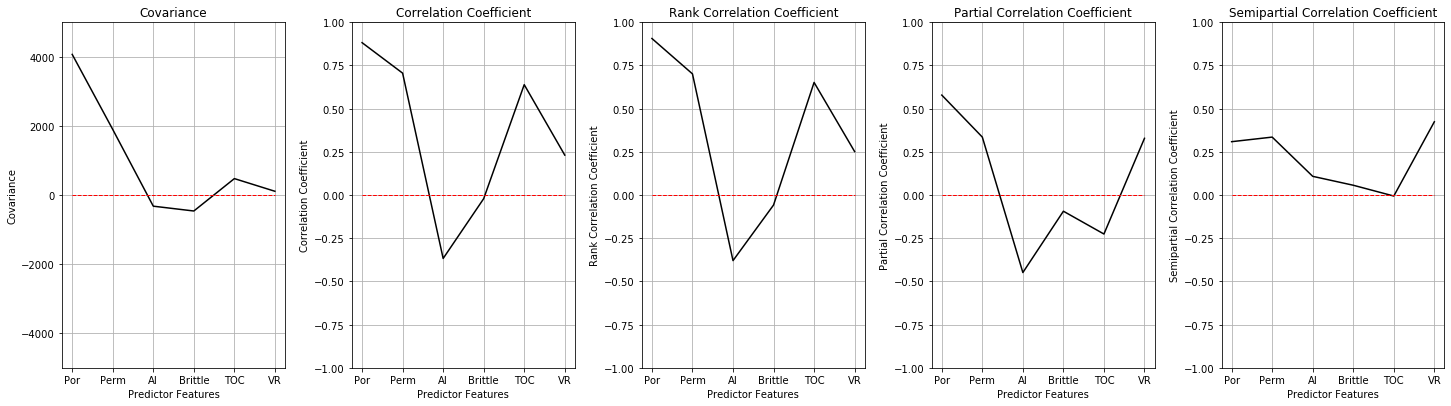

In [19]:
features = df.columns.values[1:][:6]
plt.subplot(151)
plt.plot(features,covariance,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Covariance')
t = plt.title('Covariance')
plt.ylim(-5000,5000)
plt.grid(True)

plt.subplot(152)
plt.plot(features,correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Correlation Coefficient')
t = plt.title('Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(153)
plt.plot(features,rank_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Rank Correlation Coefficient')
t = plt.title('Rank Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(154)
plt.plot(features,partial_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Partial Correlation Coefficient')
t = plt.title('Partial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(155)
plt.plot(features,semipartial_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Semipartial Correlation Coefficient')
t = plt.title('Semipartial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

I think we are converging on porosity, permeability and vitrinite reflectance as the most important variables with respect to linear relationships with the production.  

### Repeat with Standardization or Normal Score Transform of All Features

Just as a check, let's standardize all the features and repeat the previously calculated quantitative methods. We know this will have an impact on covariance, what about the partial and semipartial correlations?

There is a bunch of code to get this done, but it isn't too complicated. First, lets make a new DataFrame with all variables standardized. Then we can make a minor edit (change the DataFrame name) and reuse the code from above. You can choose between:

1. Afine Correction - scale the distributions to have $\overline{x} = 0$ and $\sigma_x = 1.0$.
2. Normal Score Transform - distribution transform of each feature to standard normal, Gaussian shape with $\overline{x} = 0$ and $\sigma_x = 1.0$.

Use this block to perform affine correction of the features:

In [20]:
dfS = pd.DataFrame()                      # affine correction of each feature, standardization to a mean of 0 and variance of 1 
dfS['Well'] = df['Well'].values
dfS['Por'] = GSLIB.affine(df['Por'].values,0.0,1.0)
dfS['Perm'] = GSLIB.affine(df['Perm'].values,0.0,1.0)
dfS['AI'] = GSLIB.affine(df['AI'].values,0.0,1.0)
dfS['Brittle'] = GSLIB.affine(df['Brittle'].values,0.0,1.0)
dfS['TOC'] = GSLIB.affine(df['TOC'].values,0.0,1.0)
dfS['VR'] = GSLIB.affine(df['VR'].values,0.0,1.0)
dfS['Prod'] = GSLIB.affine(df['Prod'].values,0.0,1.0)
dfS.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,-0.982256,-0.817030,-0.298603,2.358297,0.352257,1.152048,-1.399936
1,2,-0.881032,-0.463751,0.444147,-0.141332,-0.213702,-0.280931,-0.553322
2,3,-0.327677,-1.008148,1.841224,1.748113,-0.213702,2.518377,-0.859996
3,4,0.903875,1.401098,-0.599240,-0.592585,0.184565,-0.280931,0.919141
4,5,0.853263,0.138561,0.373409,-2.640962,1.085907,-0.214280,-0.648602


Use this block to perform normal score transform of the features:

In [21]:
dfS = pd.DataFrame()                      # Gaussian transform of each feature, standardization to a mean of 0 and variance of 1 
dfS['Well'] = df['Well'].values
dfS['Por'],d1,d2 = geostats.nscore(df,'Por')
dfS['Perm'],d1,d2 = geostats.nscore(df,'Perm')
dfS['AI'],d1,d2 = geostats.nscore(df,'AI')
dfS['Brittle'],d1,d2 = geostats.nscore(df,'Brittle')
dfS['TOC'],d1,d2 = geostats.nscore(df,'TOC')
dfS['VR'],d1,d2 = geostats.nscore(df,'VR')
dfS['Prod'],d1,d2 = geostats.nscore(df,'Prod')
dfS.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,-0.964092,-0.780664,-0.285841,2.432379,0.312053,1.114651,-1.780464
1,2,-0.832725,-0.378580,0.446827,-0.195502,-0.272809,-0.325239,-0.392079
2,3,-0.312053,-1.069155,1.722384,2.004654,-0.272809,2.241403,-0.832725
3,4,0.730638,1.325516,-0.531604,-0.590284,0.131980,-0.325239,0.815126
4,5,0.698283,0.298921,0.365149,-2.870033,1.047216,-0.259823,-0.531604


Regardless of transform that you chose it it good to check the summary statistics.  

In [22]:
dfS.describe()                            # check the summary statistics

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
count,200.000000,200.000000,200.000000,2.000000e+02,2.000000e+02,200.000000,200.000000,2.000000e+02
mean,100.500000,-0.009700,0.010306,9.732356e-03,8.028717e-05,0.016625,0.017360,1.617223e-03
std,57.879185,1.040456,1.005488,1.000221e+00,1.000278e+00,0.983649,1.000401,9.949811e-01
min,1.000000,-4.991462,-3.355431,-2.782502e+00,-2.870033e+00,-2.108358,-2.899210,-2.483589e+00
25%,50.750000,-0.670577,-0.647337,-6.588985e-01,-6.705770e-01,-0.670577,-0.651072,-6.705770e-01
50%,100.500000,0.006267,0.006267,8.881784e-16,8.881784e-16,0.018807,0.006267,8.881784e-16
75%,150.250000,0.670577,0.678574,6.705770e-01,6.705770e-01,0.682378,0.682642,6.705770e-01
max,200.000000,2.807034,2.807034,2.807034e+00,2.807034e+00,2.807034,2.807034,2.807034e+00


We should also check the matrix scatter plot again.

* If you performed normal score transform, you have standardized the mean and variance and correct the univariate shape of the distribution, but the bivariate relationships still depart from Gaussian.

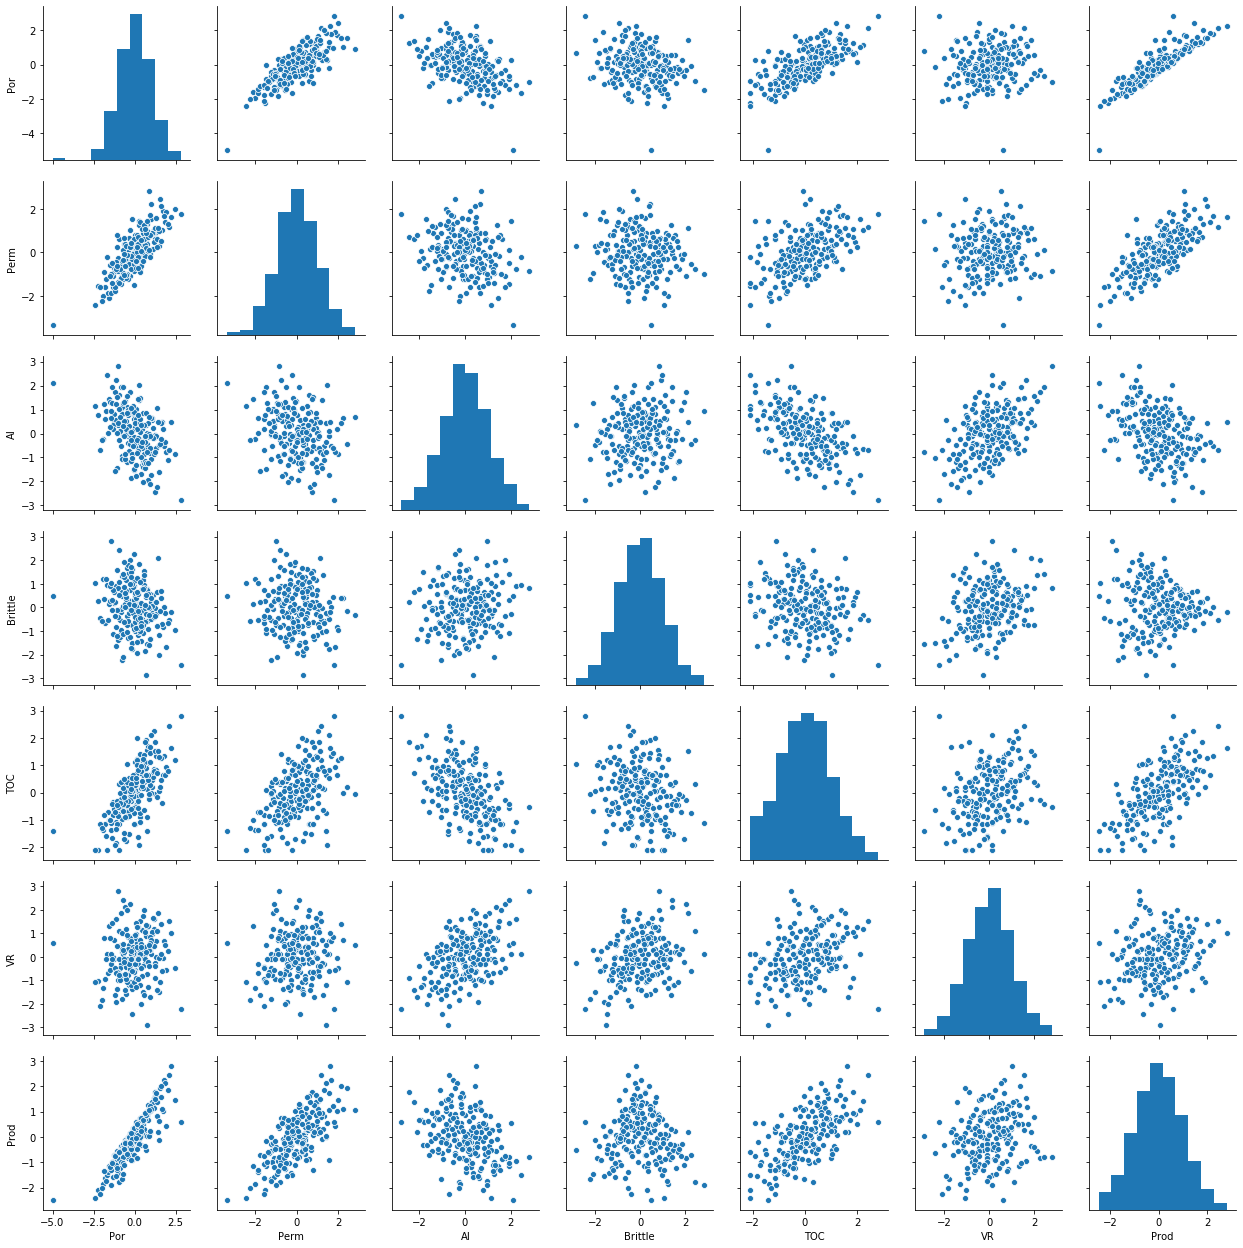

In [23]:
sns.pairplot(dfS,vars=['Por','Perm','AI','Brittle','TOC','VR','Prod'],markers='o')

This is the new DataFrame with standardized variables. Now we repeat the previous calculations. We will be more efficient this time and use quite compact code.

In [24]:
stand_covariance = dfS.iloc[:,1:8].cov().iloc[6,:6]
stand_correlation = dfS.iloc[:,1:8].corr().iloc[6,:6]
stand_rank_correlation, stand_rank_correlation_pval = stats.spearmanr(dfS.iloc[:,1:8])
stand_rank_correlation = stand_rank_correlation[:,6][:6]
stand_rank_correlation_pval = stand_rank_correlation_pval[:,6][:6]
stand_partial_correlation = partial_corr(dfS.iloc[:,1:8])
stand_partial_correlation = stand_partial_correlation[:,6][:6]
stand_semipartial_correlation = semipartial_corr(dfS.iloc[:,1:8])
stand_semipartial_correlation = stand_semipartial_correlation[:,6][:6]

and repeat the previous summary plot.

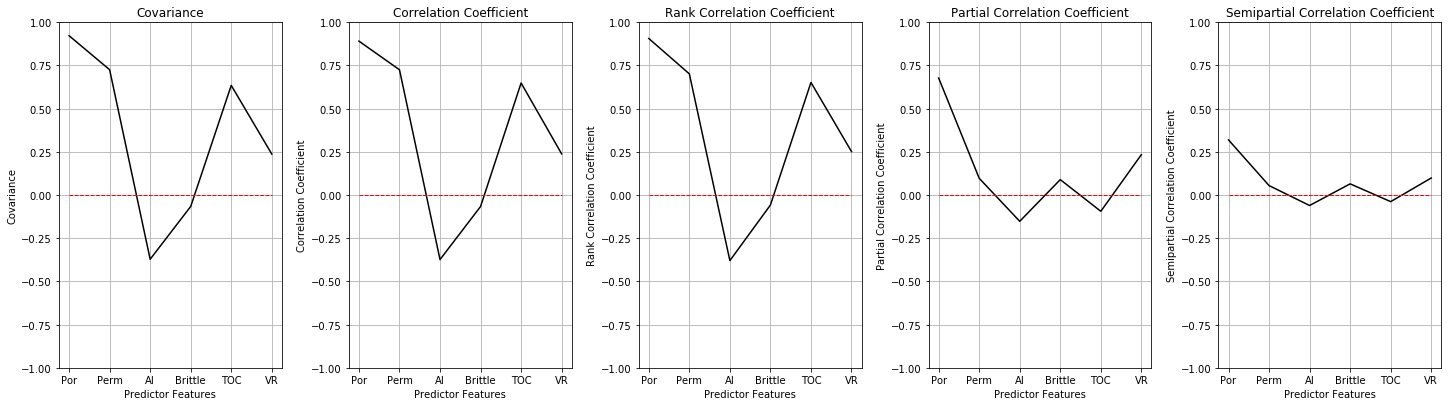

In [25]:
features = df.columns.values[1:][:6]
plt.subplot(151)
plt.plot(features,stand_covariance,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Covariance')
t = plt.title('Covariance')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(152)
plt.plot(features,stand_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Correlation Coefficient')
t = plt.title('Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(153)
plt.plot(features,stand_rank_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Rank Correlation Coefficient')
t = plt.title('Rank Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(154)
plt.plot(features,stand_partial_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Partial Correlation Coefficient')
t = plt.title('Partial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(155)
plt.plot(features,stand_semipartial_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Semipartial Correlation Coefficient')
t = plt.title('Semipartial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

What should you observe:

* covariance is now equal to correlation coefficient
* the semipartial correlations are sensitive to the feature standardization (affine correlation or normal score transform).

### Conditional Statistics

We will separate the wells into low, mid and high production and access the difference in the conditional statistics.  

* This will provide a more flexible method to compare the relationship between each feature and production

* If the conditional statistics change significantly then that feature is informative

We are going to make a single violin plot over all of our features

* We need a cateogrical feature for production, we truncate production to High or Low

```python
df['tProd'] = np.where(df['Prod']>=4000, 'High', 'Low') 
```

* We will need to standardize all of our features so we can observe their relative differences together

```python
x = df[['Por','Perm','AI','Brittle','TOC','VR']]
x_stand = (x - x.mean()) / (x.std())      
```
* This code extracted the features into a new DataFrame 'x', then applied the standardization operation on each column (feature)

* Then we add the truncated production feature into the standardized features

```python 
x = pd.concat([df['tProd'],x_stand.iloc[:,0:6]],axis=1)
```

* We can then apply the melt command to unpivot the DataFrame

```python
x = pd.melt(x,id_vars="tProd",var_name="Predictors",value_name='Standardized_Value')
```

* We now have a long DataFrame (6 features x 200 samples = 12000 rows) with:

    * production: Low or High
    * features: Por, Perm, AI, Brittle, TOC or VR
    * standardized feature value
    
We can then build our violin plot 

* x is our predictor features
* y is the standardized values for the predictor features (all now in one column)
* hue is the production level High or Low
* split is True so the violins are split in half
* inner is quartiles for P25, P50 and P75 are plotted as dashed lines

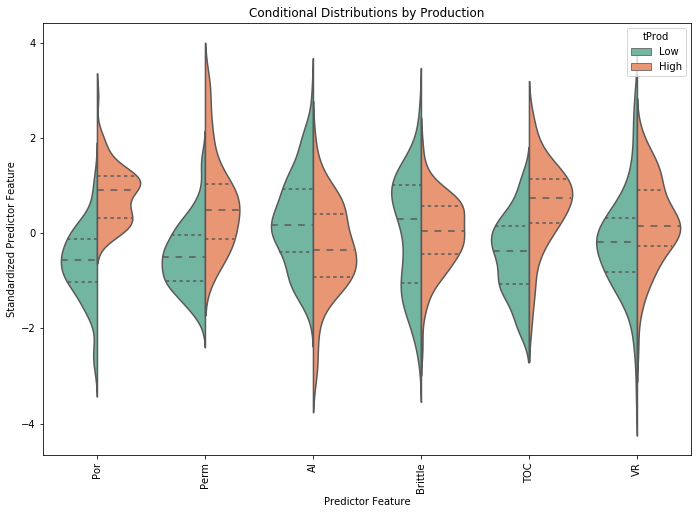

In [26]:
df['tProd'] = np.where(df['Prod']>=4000, 'High', 'Low') # make a high and low production categorical feature

x = df[['Por','Perm','AI','Brittle','TOC','VR']]
x_stand = (x - x.mean()) / (x.std())      # standardization by feature
x = pd.concat([df['tProd'],x_stand.iloc[:,0:6]],axis=1) # add the production categorical feature to the DataFrame
x = pd.melt(x,id_vars="tProd",var_name="Predictor Feature",value_name='Standardized Predictor Feature') # unpivot the DataFrame

plt.subplot(111)
sns.violinplot(x="Predictor Feature", y="Standardized Predictor Feature", hue="tProd", data=x,split=True, inner="quart", palette="Set2")
plt.xticks(rotation=90); plt.title('Conditional Distributions by Production')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

From the violin plot we can observe that the conditional distributions of porosity, permeability, TOC have the most variation between low and high production wells.

We can replace the plot with box and whisker plots of the conditional distributions.  

* Box and whisker plots improve our ability to observe outliers

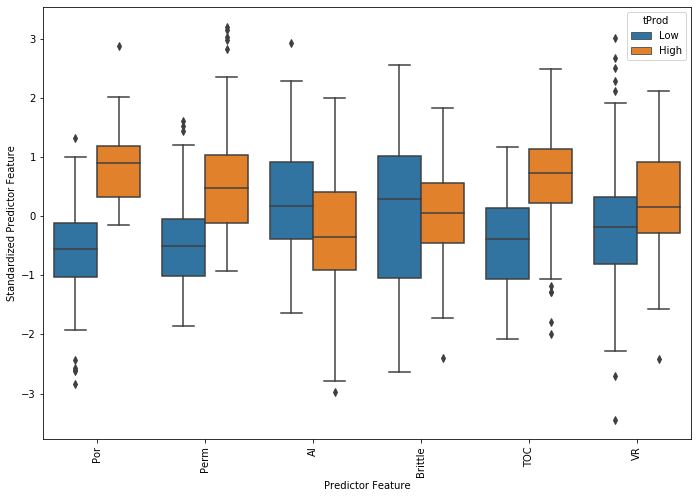

In [27]:
plt.subplot(111)
sns.boxplot(x="Predictor Feature", y="Standardized Predictor Feature", hue="tProd", data=x)
plt.xticks(rotation=90)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

df = df.drop(['tProd'], axis = 1)

From the conditional box plot we can observe that the conditional distributions of porosity, permeability, TOC have the most variation between low and high production wells.

* We can observed the outliers in porosity, permeability (upper tail), total organic carbon (lower tail) and vitrinite reflectance. 

For our last statistical summary, let's try mutual information.  

### Mutual Information

Mutual information is a generalized approach that quantifies the mutual dependence between two features.  

* quantifies the amount of information gained from observing one feature about the other

* avoids any assumption about the form of the relationship (e.g. no assumption of linear relationship)

* compares the joint probabilities to the product of the marginal probabilities

For discrete or binned continuous features $X$ and $Y$, mutual information is calculated as:

\begin{equation}
I(X;Y) = \sum_{y \in Y} \sum_{x \in X}P_{X,Y}(x,y) log \left( \frac{P_{X,Y}(x,y)}{P_X(x) \cdot P_Y(y)} \right)
\end{equation}

recall for indepedence:

\begin{equation}
P_{X,Y}(x,y) = P_X(x) \cdot P_Y(y)
\end{equation}

therefore if the two features are independent then the $log \left( \frac{P_{X,Y}(x,y)}{P_X(x) \cdot P_Y(y)} \right) = 0$

The joint probability $P_{X,Y}(x,y)$ is a weighting term on the sum and enforces closure.

* parts of the joint distribution with greater density have greater impact on the mutual information metric

For continuous (and nonbinned) features we can applied the integral form.

\begin{equation}
I(X;Y) = \int_{Y} \int_{X}P_{X,Y}(x,y) log \left( \frac{P_{X,Y}(x,y)}{P_X(x) \cdot P_Y(y)} \right) dx dy
\end{equation}

We get a sorted list of the indices in decreasing order of importance with the command

```python
indices = np.argsort(importances)[::-1]
```

the slice reverses the order, for descending order of importance.

Feature ranking:
1. feature Por = 1.000000
2. feature Perm = 0.345919
3. feature TOC = 0.273881
4. feature Brittle = 0.073557
5. feature AI = 0.052581
6. feature VR = 0.008426


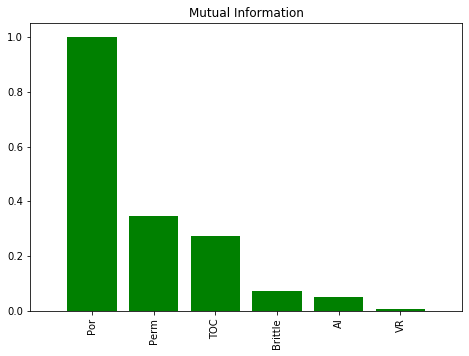

In [28]:
from sklearn.feature_selection import mutual_info_regression

x = df.iloc[:,[1,2,3,4,5,6]]              # separate DataFrames for predictor and response features
y = df.iloc[:,[7]]

mi = mutual_info_regression(x,np.ravel(y)) # calculate mutual information
mi /= np.max(mi)                          # calculate relative mutual information

indices = np.argsort(mi)[::-1]            # find indicies for descending order

print("Feature ranking:")                 # write out the feature importances
for f in range(x.shape[1]):
    print("%d. feature %s = %f" % (f + 1, x.columns[indices][f], mi[indices[f]]))

plt.subplot(111)                          # plot the relative mutual information 
plt.title("Mutual Information")
plt.bar(range(x.shape[1]), mi[indices],
       color="g", align="center")
plt.xticks(range(x.shape[1]), x.columns[indices],rotation=90)
plt.xlim([-1, x.shape[1]])
plt.subplots_adjust(left=0.0, bottom=0.0, right=1., top=1., wspace=0.2, hspace=0.2)
plt.show()


From mutual information we can observe that porosity, permeability then totoal organic carbon adn brittleness have the greatest departure from general independence.  

#### Sequential mRMR for Feature Ranking

A practical workflow (Peng et al., 2005) is to: 

1. discretize the data to reduce the high dimensional PDF inference problem.

2. Calculate the univariate mutual information (each predictor feature with the response), select the feature with the highest mutual information

3. Calculate the Peng et al. (2005) mRMR (minimum Redudancy, Maximum Relevance) measure for all cases with the original selected feature and one more feature, add the feature with the highest score

4. Calculate the Peng et al. (2005) mRMR (minimum Redudancy, Maximum Relevance) measure for all cases with the original two selected feature and one more feature, add the feature with the highest score

5. Repeat until all features are added.

The code below performs a single (by-hand) step of the sueqential mRMR for any subset of features.

The steps include:

* quantile transformation of the data to $[-1, 0, 1]$ for lower, middle and upper 1/3 of the distribution (equal proportions).

* indicate the previously select features

* indicate the proposed feature to add to the selected features

* calculate the redudancy measure (Wi), average of mutual information between the proposed feature and the previously selected feature

* calculate the relevance measure (Vi), the mutual information between the proposed feature and the response feature.

In [61]:
# Implimentation of Feature Ranking (Peng et al., 2005)
df['dPor'] = pd.qcut(df['Por'],3,labels=[-1,0,1])
df['dPerm'] = pd.qcut(df['Perm'],3,labels=[-1,0,1])
df['dTOC'] = pd.qcut(df['TOC'],3,labels=[-1,0,1])
df['dBrittle'] = pd.qcut(df['Brittle'],3,labels=[-1,0,1])
df['dAI'] = pd.qcut(df['AI'],3,labels=[-1,0,1])
df['dVR'] = pd.qcut(df['VR'],3,labels=[-1,0,1])
df['dProd'] = pd.qcut(df['Prod'],3,labels=[-1,0,1])

# indicate the previously selected feature (Prev_Sub), proposed feature to add (Prop) and the response feature (Res)  
Prev_Sub = [8,10,13]; Prop = 9; Res = 14
print('Pevious Selected Features, Predictors = ', end=" ")
for i in Sub:
    print(df.columns[i], end=" ")
print(', Proposed = ' + df.columns[Prop])  
print(', Response = ' + df.columns[Res])

nPrev_Sub = len(Prev_Sub)

# calculate the predictor_i,j feature mutual information matrix
Ixx_mat = np.zeros([len(Prev_Sub)]); 

ii = 0
for i in Prev_Sub:
    Ixx_mat[ii] = mutual_info_regression(df.iloc[:,[i]].values.reshape(-1, 1),
         np.ravel(df.iloc[:,[Prop]].values.reshape(-1, 1)))
    ii = ii + 1
Ixx_mat = np.round(Ixx_mat,3)
print('\nMutual Information between all predictor features and proposed addition:')
print(Ixx_mat)

Wi = np.round(np.average(Ixx_mat),4)

print('\nRedundancy (W_I) is ' + str(Wi) + '.')

# calculate the predictor_i, response mutual information vector
Ixy = mutual_info_regression(df.iloc[:,[Prop]].values.reshape(-1, 1),
         np.ravel(df.iloc[:,[Res]].values.reshape(-1, 1)))
Ixy = np.round(Ixy,3)

print('\nMutual Information between all predictor feature and the proposed feature, Vi:')
print(Ixy)

Vi = np.round(np.average(Ixy_mat),4)

print('\nRelevance (V_I) is ' + str(Vi) + '.')

mRMR = Vi - Wi

print('\nMinimum redundancy maximum relevance score = ' + str(round(mRMR,3)))

Pevious Selected Features, Predictors =  dPor dPerm dTOC dVR , Proposed = dPerm
, Response = dProd

Mutual Information between all predictor features and proposed addition:
[0.282 0.041 0.006]

Redundancy (W_I) is 0.1097.

Mutual Information between all predictor feature and the proposed feature, Vi:
[0.227]

Relevance (V_I) is 0.234.

Minimum redundancy maximum relevance score = 0.124


Here we demonstrate the calculation of redudancy and relevance over an entire subset of features.

UNDER CONSTRUCTION

In [57]:
# Implimentation of Feature Ranking (Peng et al., 2005)
df['dPor'] = pd.qcut(df['Por'],3,labels=[-1,0,1])
df['dPerm'] = pd.qcut(df['Perm'],3,labels=[-1,0,1])
df['dTOC'] = pd.qcut(df['TOC'],3,labels=[-1,0,1])
df['dBrittle'] = pd.qcut(df['Brittle'],3,labels=[-1,0,1])
df['dAI'] = pd.qcut(df['AI'],3,labels=[-1,0,1])
df['dVR'] = pd.qcut(df['VR'],3,labels=[-1,0,1])
df['dProd'] = pd.qcut(df['Prod'],3,labels=[-1,0,1])

#Sub = [8,9,10,11,12,13]
Sub = [8,9,10,13]; Res = 14
print('Selected Features, Predictors = ', end=" ")
for i in Sub:
    print(df.columns[i], end=" ")
    
print(', Response = ' + df.columns[Res])

nSub = len(Sub)

# calculate the predictor_i,j feature mutual information matrix
Ixx_mat = np.zeros([len(Sub),len(Sub)]); Ixy_mat = np.zeros([len(Sub)])  

ii = 0
for i in Sub:
    jj = 0
    for j in Sub:
        Ixx_mat[ii,jj] = mutual_info_regression(df.iloc[:,[i]].values.reshape(-1, 1),
         np.ravel(df.iloc[:,[j]].values.reshape(-1, 1)))
        jj = jj + 1
    ii = ii + 1
Ixx_mat = np.round(Ixx_mat,3)
print('\nMutual Information between all predictor features:')
print(Ixx_mat)

Wi = np.round(np.average(Ixx_mat),4)

print('\nRedundancy (W_I) is ' + str(Wi) + '.')

# calculate the predictor_i, response mutual information vector
ii = 0
for i in Sub:
    Ixy_mat[ii] = mutual_info_regression(df.iloc[:,[i]].values.reshape(-1, 1),
         np.ravel(df.iloc[:,[Res]].values.reshape(-1, 1)))
    Ixy_mat = np.round(Ixy_mat,3)
    ii = ii + 1

print('\nMutual Information between all predictor features and the response feature:')
print(Ixy_mat)

Vi = np.round(np.average(Ixy_mat),4)

print('\nRelevance (V_I) is ' + str(Vi) + '.')

mRMR = np.average(Ixy_mat) - np.average(Ixx_mat)

print('\nMinimum redundancy maximum relevance score = ' + str(round(mRMR,3)))

Selected Features, Predictors =  dPor dPerm dTOC dVR , Response = dProd

Mutual Information between all predictor features:
[[1.126 0.352 0.195 0.016]
 [0.237 1.08  0.131 0.   ]
 [0.196 0.    1.099 0.021]
 [0.    0.    0.008 1.093]]

Redundancy (W_I) is 0.3471.

Mutual Information between all predictor features and the response feature:
[0.502 0.175 0.221 0.038]

Relevance (V_I) is 0.234.

Minimum redundancy maximum relevance score = -0.113


Check the transformation, discritization of the features.

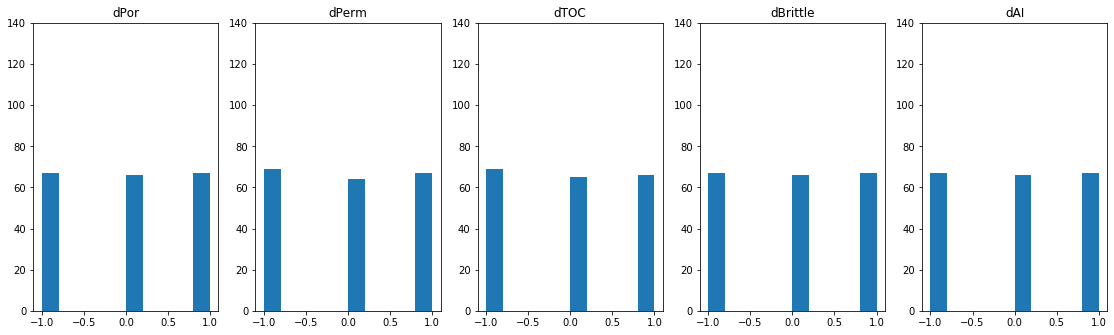

In [49]:
df['dPor'] = pd.qcut(df['Por'],3,labels=[-1,0,1])
df['dPerm'] = pd.qcut(df['Perm'],3,labels=[-1,0,1])
df['dTOC'] = pd.qcut(df['TOC'],3,labels=[-1,0,1])
df['dBrittle'] = pd.qcut(df['Brittle'],3,labels=[-1,0,1])
df['dAI'] = pd.qcut(df['AI'],3,labels=[-1,0,1])
df['dVR'] = pd.qcut(df['VR'],3,labels=[-1,0,1])
df['dProd'] = pd.qcut(df['Prod'],3,labels=[-1,0,1])
plt.subplot(161)
plt.hist(df['dPor'].values); plt.title('dPor'); plt.ylim([0,140])
plt.subplot(162)
plt.hist(df['dPerm'].values); plt.title('dPerm'); plt.ylim([0,140])
plt.subplot(163)
plt.hist(df['dTOC'].values); plt.title('dTOC'); plt.ylim([0,140])
plt.subplot(164)
plt.hist(df['dBrittle'].values); plt.title('dBrittle'); plt.ylim([0,140])
plt.subplot(165)
plt.hist(df['dAI'].values); plt.title('dAI'); plt.ylim([0,140])
plt.subplots_adjust(left=0.0, bottom=0.0, right=3., top=1., wspace=0.2, hspace=0.2)
plt.show()


From mutual information we can observe that porosity, permeability then totoal organic carbon adn brittleness have the greatest departure from general independence.  

## Model-based Feature Ranking 

With these methods we evaluate the performance of the features in building an actual predictive model. Let's start with $B$ coefficients.

### Ranking Method - $B$ Coefficients / Beta Weights 

We could also consider $B$ coefficients.  These are the linear regression coefficients without standardization of the variables. Let's use the linear regression method that is available in the SciPy package.

The estimator for $Y$ is simply the linear equation:

\begin{equation}
Y^* = \sum_{i=1}^{m} b_i X_i + c
\end{equation}

The $b_i$ coefficients are solved to minimize the squared error between the estimates, $Y^*$ and the values in the training dataset, $Y$.

In [31]:
df['const'] = np.ones(len(df))                  # let's add one for the constant term
b = linalg.lstsq(df.iloc[:,[1,2,3,4,5,6,8]],df.iloc[:,[7]])[0]
df = df.drop('const',axis = 1)
print(b[0:6])

ValueError: object arrays are not supported

The ouput is the $b$ coefficients, ordered over our features from $b_i, i = 1,\ldots,n$ and then the intercept, $c$, that I have removed to avoid confusion.

* we see the negative contribution of AI and TOC
* the results are very sensitive to the magnitudes of the variances of the predictor features. 

We can remove this sensitivity by working with standardized features.

### Ranking Method - $\beta$ Coefficients / Beta Weights 

$\beta$ coefficients are calculated as the linear regression of the coefficients after we have standardized the predictor and response features to have a variance of one.  

\begin{equation}
\sigma^2_{X^s_i} = 1.0 \quad \forall \quad i = 1,\ldots,m, \quad \sigma^2_{Y^s} = 1.0
\end{equation}

The estimator for $Y^s$ standardized is simply the linear equation:

\begin{equation}
Y^{s*} = \sum_{i=1}^{m} \beta_i X^s_i + c
\end{equation}

It is convenient that we have just standardized all our variables to have a variance of 1.0 just recently (see above). Let's use the same linear regression method again on the standardized features to get $\beta$ coefficients. 

In [ ]:
dfS['const'] = np.ones(len(df))           # let's add one for the constant term
beta = linalg.lstsq(dfS.iloc[:,[1,2,3,4,5,6,8]],dfS.iloc[:,[7]])[0]
dfS = dfS.drop('const',axis = 1)
print(beta[0:6])   

Some observations:

* the change between $b$ and $\beta$ coefficients is not just a constant scaling

* porosity, acoustic impedance and total organic carbon have the great weight in the estimate of production


### Ranking Method - Feature Importance

A variety of machine learning methods provide measures of feature importance.  

* for exaple decision trees track the reduction in mean square error through inclusion of each feature

Let's look at the feature importance from a random forest regressor fit to our data.

* We will instantiate a random forest with default hyperparameters. This results in unlimited complexity, over-trained trees in our forest. The averaging of these trees takes care of the overfit issue.

* Then we will train our random forest and extract the importances (expectation over all the trees)

* we can also extract the feature importances over all the trees in the forest and summarize with the standard deviation to access the robustness of our feature importance measure

In [ ]:
# Code modified from https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
import warnings                           # silence warnings that commonly occur with random forest
warnings.filterwarnings('ignore')     

x = df.iloc[:,[1,2,3,4,5,6]]              # separate DataFrames for predictor and response features
y = df.iloc[:,[7]]

lab_enc = preprocessing.LabelEncoder(); y_encoded = lab_enc.fit_transform(y) # this removes an encoding error 

random_forest = RandomForestRegressor()   # instantiate the random forest  
random_forest = random_forest.fit(x,np.ravel(y_encoded)) # fit the random forest
importances = random_forest.feature_importances_ # extract the expected feature importances
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_],axis=0) # calculate stdev over trees
indices = np.argsort(importances)[::-1]   # find indicies for descending order

print("Feature ranking:")                 # write out the feature importances
for f in range(x.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.subplot(111)                          # plot the feature importance 
plt.title("Feature importances")
plt.bar(range(x.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(x.shape[1]), x.columns[indices],rotation=90)
plt.xlim([-1, x.shape[1]])
plt.subplots_adjust(left=0.0, bottom=0.0, right=1., top=1., wspace=0.2, hspace=0.2)
plt.show()

There is more we can do with model-based methods. We will actually test models to assess the incremental impact of each predictor feature! We will try this with recursive feature elimination.

Let's plot the results from the $B$ and $\beta$ coefficients and compare with the previous results.

In [ ]:
plt.subplot(151)
plt.plot(features,rank_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Rank Correlation Coefficient')
t = plt.title('Rank Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(152)
plt.plot(features,partial_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Partial Correlation Coefficient')
t = plt.title('Partial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(153)
plt.plot(features,semipartial_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Semipartial Correlation Coefficient')
t = plt.title('Semipartial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(154)
plt.plot(features,b[0:6],color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('B Coefficients')
t = plt.title('B Coefficient')
plt.ylim(-5000,5000)
plt.grid(True)

plt.subplot(155)
plt.plot(features,beta[0:6],color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Beta Coefficient')
t = plt.title('Beta Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

We have a wide array of criteria to rank our features.  

* the $B$ coefficient have the same issue as covariance, sensitivity to the univariate variance

* the $\beta$ coefficients remove this sensitivity and are consistent with previous results.

Given all of these methods, I would rank the variables as:

1. Porosity
2. Vitrinite Reflectance
3. Acoustic Impedance
4. Permeability
5. Total Organic Carbon
6. Brittleness

I have assigned these ranks by observing the general trend in these matrics.  Of course, we could make a more quantitative score and rank by weighting each method.

As mentioned before, we should not neglect expert knowledge. If additional information is known about physical processes, causation, and reliability and availability of variables this should be integrated into assigning ranks.

We include a bonus method here, recursive feature elimination, but only provide a simple linear regression model example. More could be done with more complicated models.

### Ranking Method - Recursive Feature Elimination 

Recursive Feature Elimination (RFE) method works by recursively removing features and building a model with the remaining features.

* for the first step, all features are used to build a model and the features are ranked by feature importance or the coeficient

* the least important feature is pruned and the model is rebuilt

* this is repeated until there is only one feature remaining

In this code we make a prediction model based on multilinear regression and indicate that we want to find the best feature based on recursive feature elimination. The algorithm assigns rank $1,\ldots,m$ for all features.

In [ ]:
rfe = RFE(LinearRegression(), 1,verbose=0) # set up RFE linear regression model
df['const'] = np.ones(len(df))            # let's add one's for the constant term
rfe = rfe.fit(df.iloc[:,[1,2,3,4,5,6,8]].values,np.ravel(df.iloc[:,[7]])) # recursive elimination
dfS = df.drop('const',axis = 1)           # remove the ones
print(rfe.ranking_[0:6])                  # print the variable ranks

The recursive feature elimination method with a linear regression model provides these ranks:

1. Total Organic Carbon
2. Vitrinite Reflectance
3. Acoustic Impedance
4. Porosity
5. Permeability
6. Brittleness

The advantages with the recursive elimination method:

* the actual model can be used in assessing feature ranks
* the ranking is based on accuracy of the estimate

but this method is sensitive to:

* choice of model
* training dataset

The feature ranks are quite different from our previous methods.  Many have moved from the previous assessment. Perhaps we should use a more flexible modeling method.

Let's repeat this method with a more flexible machine learning method, decision tree regressor.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')            

rfe = RFE(RandomForestRegressor(max_depth=3), 1,verbose=0)      # set up RFE linear regression model
df['const'] = np.ones(len(df))            # let's add one's for the constant term

x = df.iloc[:,[1,2,3,4,5,6]].values
y = df.iloc[:,[7]]

lab_enc = preprocessing.LabelEncoder(); y_encoded = lab_enc.fit_transform(y)

rfe = rfe.fit(x,np.ravel(y_encoded))      # recursive elimination
dfS = df.drop('const',axis = 1)           # remove the ones
print(rfe.ranking_[0:6])                  # print the variable ranks

The recursive feature elimination method with a linear regression model provides these ranks:

1. Porosity
2. Brittleness
3. Vitrinite Reflectance
4. Permeability
5. Total Organic Carbon
6. Acoustic Impedance

This method may be applied with cross validation (k fold iteration of training and testing datasets).  



#### Comments

This was a basic demonstration of multivariate feature ranking. A lot more could be done:  

* recursive feature elimination with more complicated models and cross validation
* principal components analysis for feature selection (mean of component loadings over all principal components for each feature)
* consideration of the spatial context of the data
* statistical testing, assignment of statistical significance and use of p-values

I have other demonstrations on the basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations, trend modeling and many other workflows available at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy. 
  
I hope this was helpful,

*Michael*

#### The Author:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)
